In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/face_reg_dataset/fer2013.csv'
data = pd.read_csv(path)
#check data shape
data.shape

(35887, 3)

In [ ]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


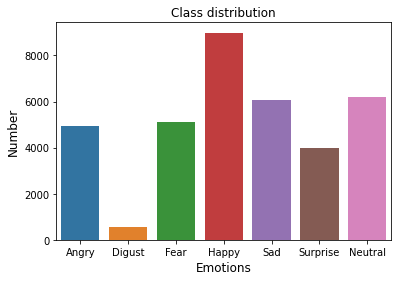

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

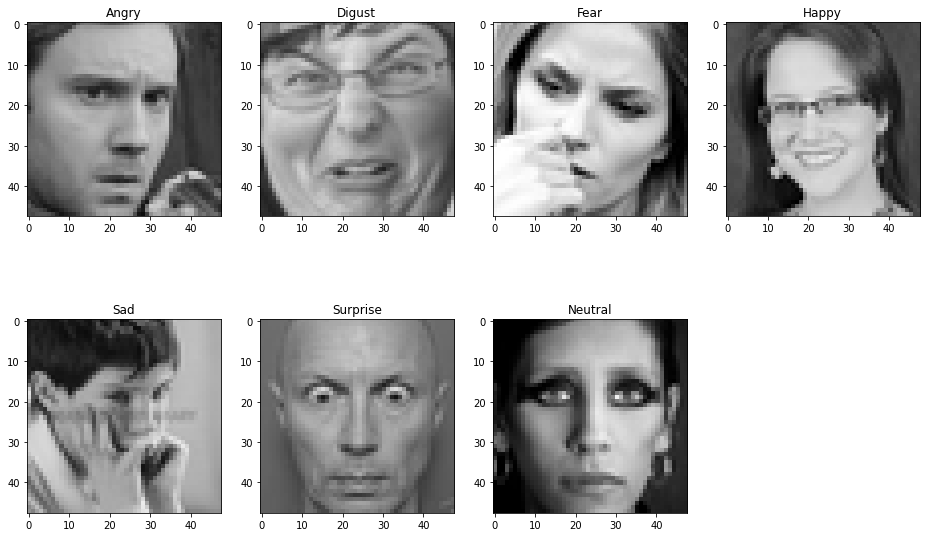

In [ ]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show() 

In [ ]:
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


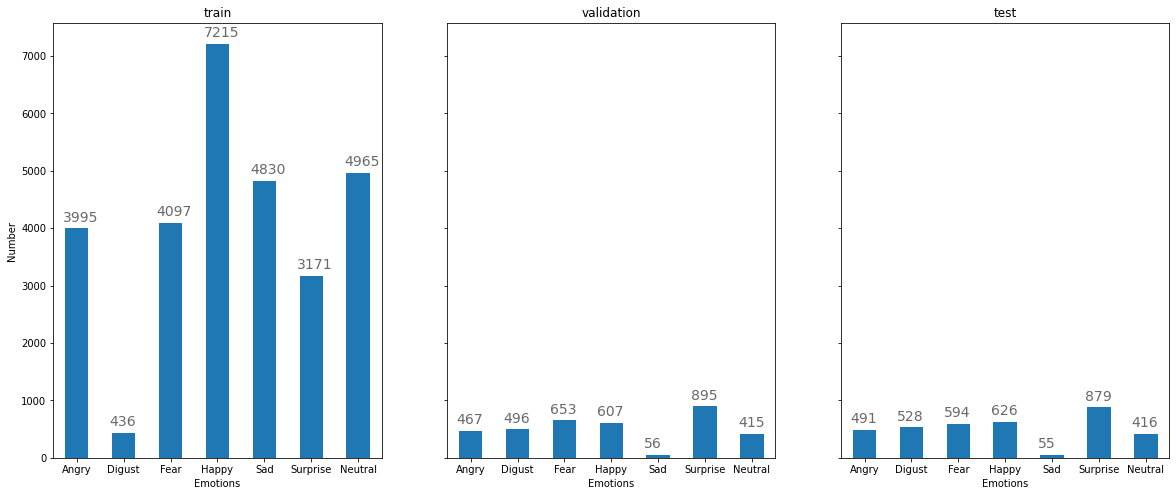

In [ ]:
emotion_labels = ['Angry', 'Digust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [ ]:
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [ ]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [ ]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
448/448 - 101s - loss: 1.6604 - accuracy: 0.3439 - val_loss: 1.8102 - val_accuracy: 0.2848 - 101s/epoch - 224ms/step
Epoch 2/50
448/448 - 85s - loss: 1.3786 - accuracy: 0.4663 - val_loss: 1.3529 - val_accuracy: 0.4728 - 85s/epoch - 189ms/step
Epoch 3/50
448/448 - 85s - loss: 1.2431 - accuracy: 0.5251 - val_loss: 1.4871 - val_accuracy: 0.4224 - 85s/epoch - 190ms/step
Epoch 4/50
448/448 - 85s - loss: 1.1716 - accuracy: 0.5553 - val_loss: 1.2638 - val_accuracy: 0.5358 - 85s/epoch - 189ms/step
Epoch 5/50
448/448 - 85s - loss: 1.1225 - accuracy: 0.5724 - val_loss: 1.4326 - val_accuracy: 0.4876 - 85s/epoch - 189ms/step
Epoch 6/50
448/448 - 85s - loss: 1.0844 - accuracy: 0.5893 - val_loss: 1.2157 - val_accuracy: 0.5508 - 85s/epoch - 189ms/step
Epoch 7/50
448/448 - 85s - loss: 1.0558 - accuracy: 0.6001 - val_loss: 1.2351 - val_accuracy: 0.5422 - 85s/epoch - 189ms/step
Epoch 8/50
448/448 - 85s - loss: 1.0316 - accuracy: 0.6098 - val_loss: 1.0789 - val_accuracy: 0.5974 - 85s/epoch - 1

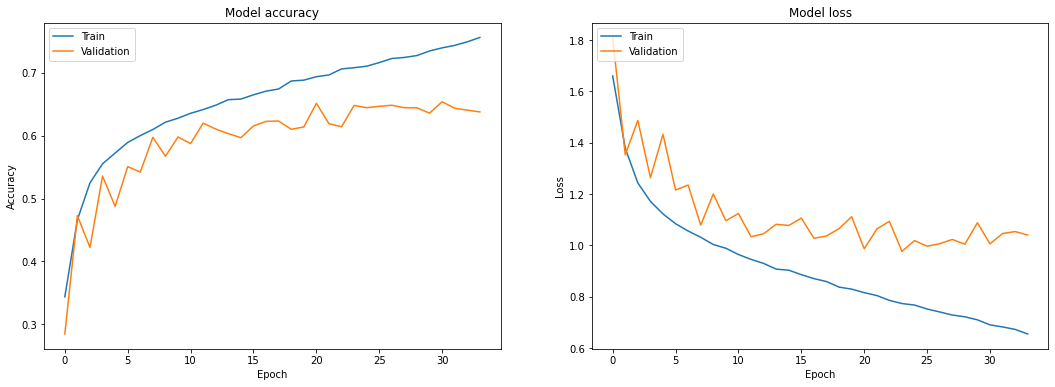

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6651


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

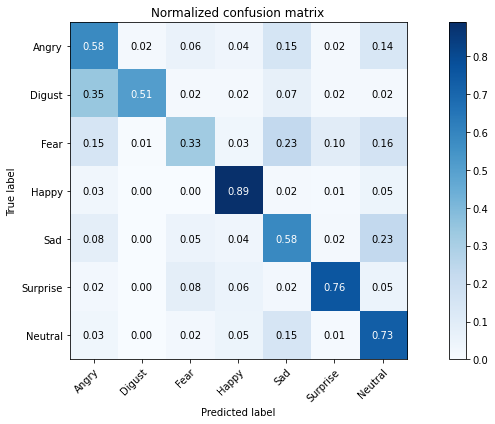

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
model.save("model.h5")

In [ ]:
model.save('/content/drive/MyDrive/face_reg_dataset/model1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/face_reg_dataset/model1/assets


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import load_model
model = load_model('example_model.h5')

In [ ]:
weights = model.get_weights()
print(weights)

[array([[[[ 0.03977949, -0.0328359 , -0.00451388, ...,  0.01702523,
           0.01370978,  0.03084408]],

        [[ 0.03537728, -0.02410604, -0.03031775, ...,  0.00971295,
           0.10911543,  0.06184788]],

        [[ 0.04082606, -0.06042095, -0.11758865, ..., -0.07948714,
           0.09735525,  0.1050942 ]]],


       [[[-0.04655695,  0.1211309 ,  0.11960886, ...,  0.00635418,
          -0.04981611, -0.0399268 ]],

        [[ 0.04406901,  0.24324234,  0.1270348 , ..., -0.03993665,
          -0.24825329, -0.09521511]],

        [[ 0.04398527, -0.06587357, -0.03465717, ..., -0.05082601,
          -0.15686126, -0.03864539]]],


       [[[-0.08873909, -0.10004774, -0.01082278, ...,  0.00932294,
           0.04358141, -0.10954417]],

        [[-0.0856614 ,  0.05861927,  0.06061861, ...,  0.00092095,
           0.12083842, -0.14860386]],

        [[ 0.01004083, -0.08823736, -0.07920569, ...,  0.10814172,
           0.07985458, -0.085802  ]]]], dtype=float32), array([ 2.02432158e-03, 